In [2]:
#this notebook is based on Igor Halperin's notebook: Trading Strategy based on PCA
#Please install: conda install -c desilinguist factor_analyzer==0.3.2

In [3]:
#this notebook is based on Igor Halperin's notebook: Trading Strategy based on PCA
#Please install: conda install -c desilinguist factor_analyzer==0.3.2

# Trading Strategy based on PCA

**For this project you will:**
- Read: https://www.researchgate.net/publication/228140014_Principal_Components_as_a_Measure_of_Systemic_Risk
- Understand how to use PCA to calculate a measure of market systemic risk (the absorption rato) as per this paper.
- Understand the use of the absorption ratio in a portfolio trading strategy (code provided in this notebook)

-Read: 
-Watch the second video in: https://utoronto-my.sharepoint.com/:u:/g/personal/rosario_trigoferre_utoronto_ca/EV06F_BwtdFNjMizMMJCI8IBSqF1tPh71loqyMLUZo2Zmg?e=PueffL
- Understand how to use an ARIMA+LSTM model to predict stock correlations as per this paper.
- Construct the ARIMA + LSTM model with the code provided in the appendix of this paper.
- Replace the covariance matrix in this notebook, cov_mat (see code below), with predicted_cov_mat. At present, cov_mat = ret_frame.cov(). 
-To construct predicted_cov_mat, calculate the covariance matrix as shown in PortfolioPresentationPart1.pptx slide 16 where the correlations are indicated with the Greek letter rho (see slide 12 for reference). Obtain the correlations by predicting them with the ARIMA + LSTM model. As per slide 16, you also need the variances indicated with the Greek letter sigma (see slide 8 for reference). A variance is just the covariance of an asset with itself.  You can predict these variances using the ARIMA + LSTM model also or you can just estimate them from historical data (as long as the lookbacks you use are consistent with the lookbacks used in the ARIMA + LSTM model).
- Once you have replaced cov_mat with predicted_cov_mat, run this notebook and comment on the results: are they better than when using the original covariance matrix? 
- You can use fewer stocks to limit the calculation time.
- Regarding the predicted_cov_mat above, you can also use a predicted_corr_mat. That is, pca can be done on either a covariance matrix of the returns or on the correlation matrix of the returns.


**Installation Instructions:**
- conda install -c desilinguist factor_analyzer

The absorption ratio was introduced by Kritzman and others in the 2010 paper, Principal Components as a Measure of Systemic Risk. The authors described the ratio as an implied measure of systemic risk that captures the extent to which markets are unified or tightly coupled.

The basic idea is to use building blocks of sub-assets to see how tightly a system of assets is trading. In this notebook we’ll use U.S. industries as the building blocks to examine the U.S. stock market. More specifically, we’ll examine linear combinations of U.S. industries  that explain the variance of the U.S. stock market. Principal Component Analysis solves this objective iteratively. PCA finds the linear combination of industries that explain the most amount of the market’s variance. Then it finds the next linear combination of industries that explain the most amount of left over variance (that is not explained by the first combination of industries). This process will be repeated until all of the variance has been explained. The absorption ratio gets its name from the idea of calculating how much of the market’s variance is “absorbed” by the first 20% of combinations of industries.

According to the paper, there are two steps to calculating a meaningful absorption ratio (AR). The first is to calculate the AR ratio and the second involves finding the standardized change of the AR ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change.

STEP 1: Formally, the ratio is defined by the variance absorbed by the first n eigenvectors:

![AR_Ratio.PNG](attachment:AR_Ratio.PNG)

The numerator equals the cumulative portion explained by the first n eigenvectors (i.e. the first n linear combinations of industries). And the denominator equals the total variance explained by all the assets (again, in this case industries). The paper suggests to set n to 1/5 of the total assets. But there are a variety of methods to find the significant stopping point for eigenvectors in PCA. You should try a number of settings for this parameter n. 

 Basically you will see that  the first combination (the first eigenvector) of industries explains more than 50% of the total variance. This reading makes sense: the U.S. industries are mostly going to trade together because they’re driven by the same underlying factor, in this case, the vector of market driven betas which is usually captured by the first eigenvector. The second combination (eigenvector) of industries (possibly representing growth stocks vs value stocks) will add to our explanation of total variance (total risk), and the next one (possibly defensive stocks vs cyclical stocks), etc. until the explained variance is over 80%. This is our absorption ratio. 
Note: the meaning of an eigenvector cannot be determined exactly

STEP 2: Having computed AR daily and put together an AR times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change In particular:

![AR_Ratio_ZValue.PNG](attachment:AR_Ratio_ZValue.PNG)

We use  𝐴𝑅 Delta  to build simple portfolio trading strategy.

### Keiser-Meyer-Olkin (KMO)

We have discussed in lecture that PCA can be used to filter "noise" away from data by the removal of some principal components, specifically those that have less importance because their eigenvalue is small compared to that of the principal components that we keep. This presupposes that the the eigenvalues that PCA outputs are NOT all going to be of similar magnitude. If the eigenvalue magnitudes are similar, that is an indication that the variables in the original data were largely uncorrelated with one another to begin with; meaning, each variable was contributing a valuable dimension, so it makes sense to keep all of them, not to get rid of some of them via PCA.  There is a rule of thumb that can be used to determine if PCA is redundant or not: if the average absolute value of the off diagonal elements of the correlation matrix of the orginal data is less than 0.3, then PCA is redundant for that data.  A more formal way making this determination is through the use of the Kaiser-Meyer-Olkin (KMO) measure.

We use the Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy (Kaiser,1970;
Kaiser and Rice,1974) to test the length of the shortest sliding window that a PCA could be
efficiently applied to. The KMO statistic compares the value of correlations between assets
(here industry ETFs) to those of the partial correlations. 
If the investigated assets share more common variation,
the KMO will be close to 1. On the other hand, a KMO near 0 indicates little common variation
and the PCA will not extract much useful information. 

The KMO statistic can also be used to assess the potential for diversification. Since the KMO
statistic measures the degree of common variation among the input assets,
one can expect less diversification opportunities (and higher market risk)
when the assets have more common variation, which means a high KMO test statistic.

As mentioned above, KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate for PCA.

See: 1. Kaiser, H. F. and Rice, J. (1974). Little jiffy. Educational and Psychological Measurement,
34(1):111–117. and 2. https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

In [4]:
import pandas as pd
import numpy as np
import sklearn.decomposition
import numpy.linalg as linalg

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.model_selection
import pandas as pd
!pip install factor_analyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import posdef

#### Dataset:  daily prices of ETFs of 20 different industries  ####
For this exercise we will be working with 20 ETFs representing 20 different industries. 
The following cell computes returns based on ETF price data. We obtain the data from WRDS as follows:

In [5]:
#1.Go to WRDS CRSP database and obtain the price and ticker data for the following industry ETFs:
#IYW IYJ IBB IGV IXP IYT VNQ PBS PBJ KCE KIE KBE XSD ITB ITA IHI IHF IHE IEZ FDN
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the prices and save the unstacked price data into a csv file called:
# 20industries_ETF_prc_UNSTACKED.csv 

In [6]:
import os
# load dataset
asset_prices = pd.read_csv('stock_prices_latest.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 21
print('Asset prices shape', asset_prices.shape)
print(asset_prices.iloc[:, :n_stocks_show].head())
print(asset_prices.iloc[:, :n_stocks_show].tail())

Asset prices shape (1458, 21)
                BTC-USD        IYW        IYJ         IBB        IGV  \
Date                                                                   
2020-01-02  6985.470215  58.085709  80.971329  118.524498  47.159706   
2020-01-03  7344.884277  57.505882  80.794868  117.011932  46.988758   
2020-01-04  7410.656738  57.505882  80.794868  117.011932  46.988758   
2020-01-05  7411.317383  57.505882  80.794868  117.011932  46.988758   
2020-01-06  7769.219238  57.860638  80.723320  117.763268  47.537388   

                  IXP        IYT        VNQ        PBS        PBJ  ...  \
Date                                                               ...   
2020-01-02  58.636944  46.719631  77.334351  32.966473  31.948799  ...   
2020-01-03  58.372860  46.397335  77.815056  32.819447  32.042793  ...   
2020-01-04  58.372860  46.397335  77.815056  32.819447  32.042793  ...   
2020-01-05  58.372860  46.397335  77.815056  32.819447  32.042793  ...   
2020-01-06  58.929333

/var/folders/tz/pry5nfj12jn20gctg0w4tvl80000gn/T/ipykernel_25623/4086494406.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  asset_prices = pd.read_csv('stock_prices_latest.csv',


### Calculate daily returns ¶

In [7]:
asset_returns = asset_prices.pct_change(periods=1)
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,BTC-USD,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,...,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.051452,-0.009982,-0.002179,-0.012762,-0.003625,-0.004504,-0.006899,0.006216,-0.004460,0.002942,...,-0.001684,-0.009495,-0.015638,0.002934,0.011434,-0.007191,-0.005008,-0.010710,0.010811,-0.007991
2020-01-04,0.008955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.048291,0.006169,-0.000886,0.006421,0.011676,0.009533,-0.005976,0.001192,0.001391,-0.002640,...,-0.000844,-0.007882,-0.006956,0.009001,0.001348,0.008380,0.010470,0.001196,0.017501,0.013901
2020-01-07,0.050774,0.000381,-0.001477,0.000252,0.002676,-0.000960,0.003494,-0.011150,0.005704,-0.007353,...,-0.007032,-0.006657,0.015430,-0.002453,0.004516,-0.002031,-0.004334,-0.002703,-0.021500,0.000844


In [8]:
def normalize_returns(r_df):
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) /sd_r
    return normed_df

In [9]:
normed_r = normalize_returns(asset_returns)
normed_r.iloc[:, :n_stocks_show].head()

,BTC-USD,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,...,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,1.424209,-0.671056,-0.190591,-0.947274,-0.254150,-0.390448,-0.501975,0.420998,-0.315017,0.273329,...,-0.138042,-0.485087,-0.792320,0.108289,0.725666,-0.590722,-0.407742,-1.062820,0.366435,-0.497355
2020-01-04,0.203902,-0.040340,-0.024434,-0.013644,-0.031061,-0.019436,-0.023140,-0.012654,-0.014868,-0.030102,...,-0.022307,-0.013012,-0.035116,-0.039651,-0.014400,-0.017975,-0.022770,-0.019091,-0.017661,-0.019754
2020-01-05,-0.050679,-0.040340,-0.024434,-0.013644,-0.031061,-0.019436,-0.023140,-0.012654,-0.014868,-0.030102,...,-0.022307,-0.013012,-0.035116,-0.039651,-0.014400,-0.017975,-0.022770,-0.019091,-0.017661,-0.019754
2020-01-06,1.333457,0.349443,-0.091952,0.456112,0.687513,0.765890,-0.437949,0.070521,0.078767,-0.302358,...,-0.080288,-0.404896,-0.371942,0.414285,0.072846,0.649540,0.782027,0.097451,0.604124,0.811060
2020-01-07,1.404745,-0.016296,-0.137063,0.004784,0.133634,-0.098546,0.219367,-0.790505,0.369042,-0.788461,...,-0.505687,-0.343955,0.712005,-0.163381,0.277897,-0.179722,-0.355902,-0.282539,-0.781531,0.030677


In [10]:
def absorption_ratio(explained_variance_arr, n_components):
    """
    Calculate absorption ratio via PCA.  
    Arguments:
    explained_variance_arr -- 1D np.array of explained variance by each pricincipal component, in descending order
    n_components -- an integer, a number of principal components to compute absorption ratio
    Formally, the ratio is defined by the variance absorbed by the first n eigenvectors
    The numerator equals the cumulative variance explained by the first n eigenvectors (=n_components) 
    And the denominator equals the total variance
    Return:
    ar -- absorption ratio
    """
    ar = np.sum(explained_variance_arr[:n_components]) / np.sum(explained_variance_arr)
    return ar

In [11]:
stock_tickers = asset_returns.columns.values[:]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

lookback_window = 252 * 1   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# require 0.8 variance to be explained. 
var_threshold = 0.8     

# fix 20% of principal components for absorption ratio calculation.
absorb_comp = int((1 / 5) * num_assets)  


print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Variance Threshold = ', var_threshold)
print('Number of assets = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

Lookback window = 252
Step size = 1
Variance Threshold =  0.8
Number of assets = 21
Number of principal components = 4


In [12]:
# indexes date on which to compute PCA
days_offset = 2 * 252 
num_days = 3 * 252 + days_offset 
pca_ts_index = asset_returns.index[list(range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size))]

# allocate arrays for storing absorption ratio
pca_components = np.array([np.nan]*len(pca_ts_index))
absorp_ratio = np.array([np.nan]*len(pca_ts_index))
kmo = np.array([np.nan]*len(pca_ts_index))

assert 'SPX' not in asset_returns.iloc[:lookback_window, :].columns.values, "By accident included SPX index"

**What this loop does**
- on each loop iteration: 
    - fits PCA to **ret_frame**
    - uses fitted pca model to pass values to absorption_ratio(). 
    - computes the number of principal components it takes to explain at least **var_threshold** of variance. The result of this calculation goes into **pca_components[ik]**. The result of the absorption ratio calculation goes into **absorp_ratio[ik]**.  The result of the KMO statistic calculation goes into **kmo[ik]**.

# Loop with sklearn.decomposition.PCA

import time

ik = 0
time_start = time.time()

for ix in range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size):
    ret_frame = normalize_returns(asset_returns.iloc[ix - lookback_window:ix, :]) # fixed window 
    ret_frame_kmo = ret_frame.copy(deep=True)
    ret_frame = ret_frame.ewm(halflife=252/12).mean()
    cov_mat = ret_frame.cov()
    
    if ik == 0 or ik % 21 == 0: 
        ### fit PCA, compute the pca components and absorption ratio 
        ### store results into pca_components[ik] and absorp_ratio[ik]
        #instantiate pca object
        pca = sklearn.decomposition.PCA()
        #fit pca to ret_frame
        pca.fit(ret_frame) 
        #Using ret_frame_kmo, calculate the KMO statistic (=kmo_total) and assign it to kmo[ik]. 
        kmo_per_variable, kmo_total=calculate_kmo(ret_frame_kmo)
        kmo[ik] = kmo_total
        #calculate the number of components needed to explain the var_threshold and assign it to pca_components[ik] 
        explained_variance = np.cumsum(pca.explained_variance_ratio_)
        pca_components[ik] = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
        #calculate the absorption ratio by calling absorption_ratio() and assign it to absorp_ratio[ik]
        #when you run this loop you can try various settings for the parameter n_components (now set to absorb_comp) in this absorption_ratio function.
        absorp_ratio[ik] = absorption_ratio(pca.explained_variance_ratio_, absorb_comp)
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1] 
        pca_components[ik] = pca_components[ik-1]
        kmo[ik] = kmo[ik-1]

    ik += 1
    
print ('Absorption Ratio done! Time elapsed: {} seconds'.format(time.time() - time_start))    
ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)

In [13]:
import time

ik = 0
time_start = time.time()

for ix in range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size):
    ret_frame = normalize_returns(asset_returns.iloc[ix - lookback_window:ix, :]) # fixed window 
    ret_frame_kmo = ret_frame.copy(deep=True)
    ret_frame = ret_frame.ewm(halflife=252/12).mean()
    cov_mat = ret_frame.cov()
    
    if ik == 0 or ik % 21 == 0: 
        ### fit PCA, compute the pca components and absorption ratio 
        ### store results into pca_components[ik] and absorp_ratio[ik]
        #instantiate pca object
        pca = sklearn.decomposition.PCA()
        #fit pca to ret_frame
        pca.fit(ret_frame) 
        #Using ret_frame_kmo, calculate the KMO statistic (=kmo_total) and assign it to kmo[ik]. 
        kmo_per_variable, kmo_total=calculate_kmo(ret_frame_kmo)
        kmo[ik] = kmo_total
        #calculate the number of components needed to explain the var_threshold and assign it to pca_components[ik] 
        explained_variance = np.cumsum(pca.explained_variance_ratio_)
        pca_components[ik] = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
        #calculate the absorption ratio by calling absorption_ratio() and assign it to absorp_ratio[ik]
        #when you run this loop you can try various settings for the parameter n_components (now set to absorb_comp) in this absorption_ratio function.
        absorp_ratio[ik] = absorption_ratio(pca.explained_variance_ratio_, absorb_comp)
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1] 
        pca_components[ik] = pca_components[ik-1]
        kmo[ik] = kmo[ik-1]

    ik += 1
    
print ('Absorption Ratio done! Time elapsed: {} seconds'.format(time.time() - time_start))    
ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)

/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose genera

Absorption Ratio done! Time elapsed: 0.49113011360168457 seconds


/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


# Loop with linalg.eig

In [14]:
# import time

# ik = 0
# time_start = time.time()

# for ix in range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size):
#     ret_frame = normalize_returns(asset_returns.iloc[ix - lookback_window:ix, :]) # fixed window 
#     ret_frame_kmo = ret_frame.copy(deep=True)
#     ret_frame = ret_frame.ewm(halflife=252/12).mean()
#     cov_mat = ret_frame.cov()
#     if not posdef.isPD(cov_mat): #make sure the cov_mat is positive definite
#         cov_mat = posdef.nearestPD(cov_mat)
        
    
#     if ik == 0 or ik % 21 == 0: 
#         ### fit PCA, compute the pca components and absorption ratio 
#         ### store results into pca_components[ik] and absorp_ratio[ik]
#         #fit pca to cov_mat
#         eigenValues, eigenVectors = linalg.eig(cov_mat) 
#         idx = eigenValues.argsort()[::-1]   
#         eigenValues_ordered = eigenValues[idx]
#         eigenVectors_ordered = eigenVectors[:,idx] #vertical eigenvectors ordered from left to right
#         #Using ret_frame_kmo, calculate the KMO statistic (=kmo_total) and assign it to kmo[ik]. 
#         kmo_per_variable, kmo_total=calculate_kmo(ret_frame_kmo)
#         kmo[ik] = kmo_total
#         #calculate the number of components needed to explain the var_threshold and assign it to pca_components[ik] 
#         explained_variance_ratio = eigenValues/np.sum(eigenValues_ordered)
#         explained_variance = np.cumsum(explained_variance_ratio)
#         pca_components[ik] = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
#         #calculate the absorption ratio by calling absorption_ratio() and assign it to absorp_ratio[ik]
#         #when you run this loop you can try various settings for the parameter n_components (now set to absorb_comp) in this absorption_ratio function.
#         absorp_ratio[ik] = absorption_ratio(explained_variance_ratio, absorb_comp)
#     else:
#         absorp_ratio[ik] = absorp_ratio[ik-1] 
#         pca_components[ik] = pca_components[ik-1]
#         kmo[ik] = kmo[ik-1]

#     ik += 1
    
# print ('Absorption Ratio done! Time elapsed: {} seconds'.format(time.time() - time_start))    
# ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
# ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)
# print(ts_absorb_ratio)

The value of the KMO statistic should be between .6 and 1. Change the number of years (with a year defined in terms of 252 trading days) in the lookback window to get the minimum KMO below to be close to 0.944286628546701. The KMO statistic and AR tell us similar information:

In [15]:
np.amin(kmo)

0.9131579422423564

In [16]:
# require 0.8 variance to be explained. How many components are needed?
print('number of components needed to explain 0.8 variance: ', pca_components[len(pca_components)-1]) 

number of components needed to explain 0.8 variance:  2.0


In [17]:
# fix 20% of principal components for absorption ratio calculation. How much variance (in %) do they explain?
print('variance explained by 20% of principal components: ', explained_variance[absorb_comp-1]) 

variance explained by 20% of principal components:  0.9234530612794739


<Axes: >

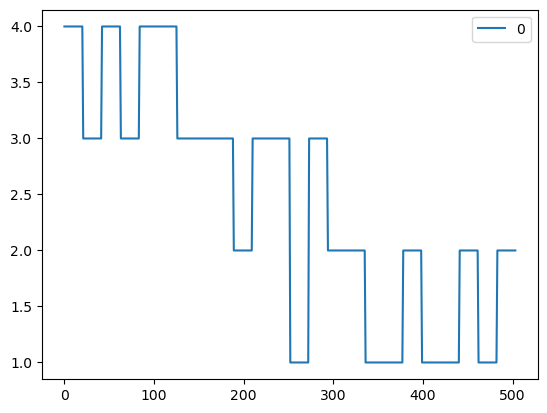

In [18]:
pd.DataFrame(pca_components).plot()

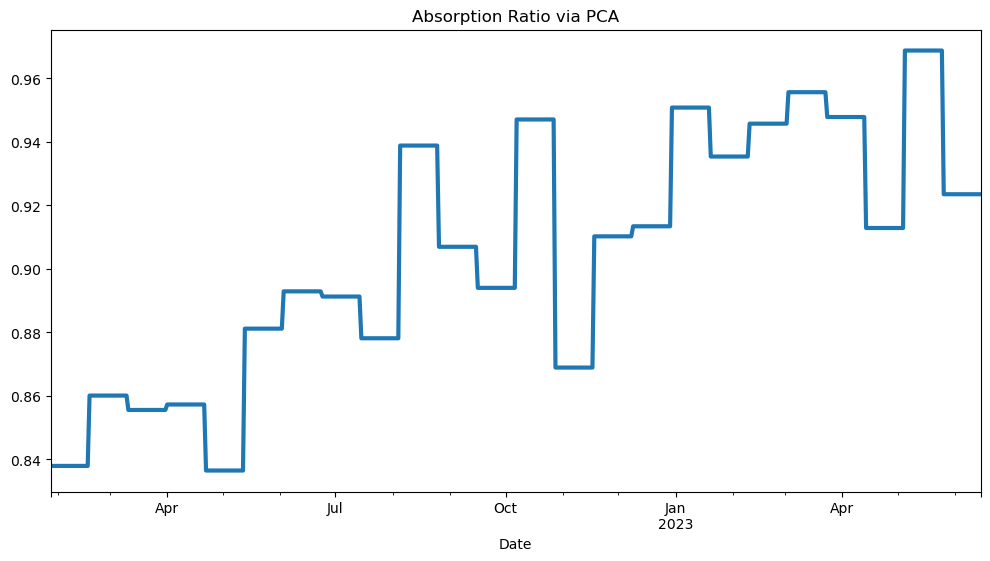

In [19]:
ts_absorb_ratio.plot(figsize=(12,6), title='Absorption Ratio via PCA', linewidth=3)
plt.savefig("Absorption_Ratio_20i.png", dpi=900)

STEP 2:
Having computed the Absorption Ratio as a daily times series, we define AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change
In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

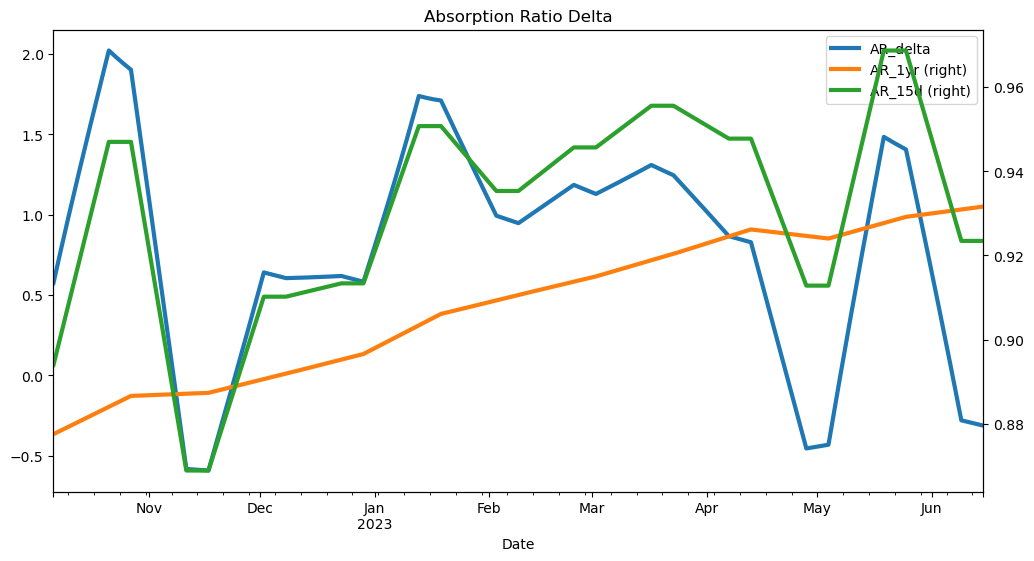

In [20]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(252).mean()
ar_mean_15d = ts_ar.rolling(15).mean()
ar_sd_1yr = ts_ar.rolling(252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr  # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values}, 
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    df_plot.plot(figsize=(12, 6), title='Absorption Ratio Delta', linewidth=3, secondary_y=['AR_1yr','AR_15d'])

#### Part 3 (AR Delta Trading Strategy)

Here we implement get_weight() function

The AR Delta trading strategy forms a portfolio of EQ (equities=stocks) and FI (fixed income=bonds), following these simple rules:

* __$ -1\sigma < AR\delta < +1\sigma $__	 50% / 50% weights for EQ / FI
* __$ AR\delta > +1\sigma $__	             0% / 100% weights for EQ / FI
* __$ AR\delta < d -1\sigma $__	             100% / 0% weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [21]:
def get_weight(ar_delta):
    '''
    Calculate EQuity / FIncome portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
    wgts = [0.0, 0.0] # replace with your own calculation here
    if ar_delta < -1:
        wgts = [1, 0]
    elif ar_delta > 1:
        wgts = [0, 1]
    else:
        wgts = [.5, .5]
    return wgts

In [22]:
#Average trades per year
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        prtf_wgts = wgts.iloc[ix, :]
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())

Average number of trades per year 4.00


/var/folders/tz/pry5nfj12jn20gctg0w4tvl80000gn/T/ipykernel_25623/1758394600.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:


Now that weights have been determined, run the re-balancing strategy using time series of returns and compute
 - sharpe of the strategy
 - strategy annualized return
 - strategy annualized volatility

Contrast this with 50 / 50 Equity / Fixed Income ETF strategy performance using the same performance metrics. Use VTI as Equity and AGG as Fixed Income assets.

In [23]:
#1. Go to WRDS CRSP database and obtain the Holding Period Return and ticker for the following industry ETFs:
# VTI AGG
#the holding period return includes dividends, coupon flows etc.
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the holding period returns and save the unstacked returns data into a csv file called:
# AGG_VTI_UNSTACKED_adjusted_returns.csv

In [24]:
#These are adjusted PERCENT returns of AGG and VTI from WRDS CRSP, including distibutions, coupons, dividends etc.
etf_percent_returns = pd.read_csv('AGG_VTI_UNSTACKED_adjusted_returns.csv')
etf_percent_returns["datadate"]=pd.to_datetime(etf_percent_returns['datadate'])
etf_percent_returns.set_index(['datadate'], inplace=True)
etf_log_returns = np.log(etf_percent_returns + 1)
#decide which return you are going to use by uncommenting a or b below (only a or b is correct, not both):
#a:
#etf_returns = etf_log_returns.copy()
#b:
etf_returns = etf_percent_returns.copy()

In [25]:
n_stocks_show = 2
print('Asset holding period returns shape', etf_returns.shape)
etf_returns.iloc[:, :n_stocks_show].head()

Asset holding period returns shape (2012, 2)


,AGG,VTI
datadate,,
2020-01-02,0.002759,0.008312
2020-01-03,0.002929,-0.006364
2020-01-06,-0.000796,0.003416
2020-01-07,-0.001063,-0.002371
2020-01-08,-0.001153,0.004936


#### Part 4 (Calculate performance of backtested strategy)

Here we implement function backtest_strategy which given a DataFrame of strategy weights and a DataFrame asset returns annualized return, volatility and Sharpe ratio of a strategy. Our solution has a shape ratio above 1 and the absorption ratio portfolio beats the equally weighted portfolio.

In [26]:
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and cumulative returns and portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    before returning plot the cumulative return of the EWM+AGG portfolio 
    '''    
    df_all=pd.merge(strat_wgts,asset_returns, left_index=True, right_index=True, how='inner')
    df_all['EQ_part'] = df_all.EQ*df_all.VTI
    df_all['FI_part'] = df_all.FI*df_all.AGG
    df_all['PORT_ret']=df_all.EQ_part+df_all.FI_part
 
    average_arithmetic_return = df_all.PORT_ret.mean()
    annualized_return = average_arithmetic_return*periods_per_year
    annualized_vol = df_all.PORT_ret.std()*np.sqrt(periods_per_year)
    annualized_sharpe = (df_all.PORT_ret.mean()/df_all.PORT_ret.std())*np.sqrt(periods_per_year) #classic definition
    #before returning plot the cumulative return of the EWM+AGG portfolio 
    df_all['PORT_ret'] = df_all.PORT_ret + 1
    df_all['Cum_PORT_ret'] = df_all.PORT_ret.cumprod()-1+1 
    df_all['Cum_PORT_ret'].plot()
    return annualized_return, annualized_vol, annualized_sharpe
   

Absorption Ratio strategy: 0.040913337620689647 0.09989043186665114 0.4095821477206842
Equally weighted: 0.1522918899310345 0.11063140507107619 1.3765701505209407


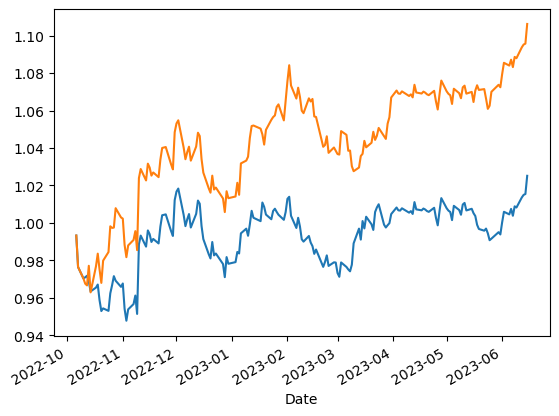

In [38]:
ann_ret, ann_vol, sharpe = backtest_strategy(wgts, etf_returns)

print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)

eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_returns)
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)

# USING sklearn.decomposition.PCA() VS USING numpy.linalg.eig()

In [28]:
pca = sklearn.decomposition.PCA()
#fit pca to ret_frame
pca.fit(ret_frame) 
#calculate the number of components needed to explain the var_threshold and assign it to pca_components[ik] 
explained_variance = np.cumsum(pca.explained_variance_ratio_)
pca_components = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
#calculate the absorption ratio by calling absorption_ratio() and assign it to absorp_ratio[ik]
#when you run this loop you can try various settings for the parameter n_components (now set to absorb_comp) in this absorption_ratio function.
absorp_ratio = absorption_ratio(pca.explained_variance_ratio_, absorb_comp)
absorp_ratio

0.9307961286092709

In [29]:
import numpy.linalg as linalg
#fit pca to the covariance matrix (ret_frame.cov() or predicted_cov_mat)
eigenValues, eigenVectors = linalg.eig(ret_frame.cov()) 
idx = eigenValues.argsort()[::-1]   
eigenValues_ordered = eigenValues[idx]
eigenVectors_ordered = eigenVectors[:,idx] #vertical eigenvectors ordered from left to right
explained_variance_ratio = eigenValues/np.sum(eigenValues_ordered)
explained_variance = np.cumsum(explained_variance_ratio)
pca_components = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
absorp_ratio = absorption_ratio(explained_variance_ratio, absorb_comp)
absorp_ratio

0.9307961286092709

In [40]:
covariance_matrix = pd.read_csv('covariance_matrix.csv', header=None)
asset_tickers = ret_frame.columns.tolist()

covariance_matrix.index = asset_tickers
covariance_matrix.columns = asset_tickers
print(covariance_matrix)
predicted_cov_mat = covariance_matrix


          BTC-USD       IYW       IYJ       IBB       IGV       IXP       IYT  \
BTC-USD  1.019809  0.618463  1.193579  0.930238  2.050490  1.745392  1.495038   
IYW      0.618463  0.778416  0.801966  1.174588  0.429816  1.177926  0.642531   
IYJ      1.193579  0.801966  0.648358  1.215570  1.422535  1.395508  1.258151   
IBB      0.930238  1.174588  1.215570  1.415871  2.163214  1.647489  1.689531   
IGV      2.050490  0.429816  1.422535  2.163214  1.678234  1.626325  1.539474   
IXP      1.745392  1.177926  1.395508  1.647489  1.626325  1.297577  1.297097   
IYT      1.495038  0.642531  1.258151  1.689531  1.539474  1.297097  1.214219   
VNQ      1.219459  1.181595  1.420941  0.939632  2.039699  1.392248  1.310646   
PBS      0.744240  0.590169  0.330358  0.923877  0.188672  0.768222  0.792719   
PBJ      0.932780  0.714293  0.497069  0.935430  0.750814  0.646950  0.467647   
KCE      0.917068  0.536409  0.709998  1.201236  1.058204  0.696028  0.971573   
KIE      0.818344  0.553458 

In [41]:
import numpy.linalg as linalg
#fit pca to the covariance matrix (ret_frame.cov() or predicted_cov_mat)
eigenValues, eigenVectors = linalg.eig(predicted_cov_mat) 
idx = eigenValues.argsort()[::-1]   
eigenValues_ordered = eigenValues[idx]
eigenVectors_ordered = eigenVectors[:,idx] #vertical eigenvectors ordered from left to right
explained_variance_ratio = eigenValues/np.sum(eigenValues_ordered)
explained_variance = np.cumsum(explained_variance_ratio)
pca_components = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
absorp_ratio = absorption_ratio(explained_variance_ratio, absorb_comp)
absorp_ratio

0.9253993155038068

The original absorption ratio was 0.931 while the absorptio ratio using the predicted covariance matrix is 0.925. There is not any significant differnce but using the predicted covariance matrix produces a smaller AR. This means with the lose of white noise the portfolio possess less volatility in the largest 20%.

In [ ]:
# correlation_matrix = pd.read_csv('correlation_matrix.csv', header=None)
# asset_tickers = ret_frame.columns.tolist()

# correlation_matrix.index = asset_tickers
# correlation_matrix.columns = asset_tickers
# print(correlation_matrix)

In [ ]:
# import numpy.linalg as linalg
# #fit pca to the covariance matrix (ret_frame.cov() or predicted_cov_mat)
# eigenValues, eigenVectors = linalg.eig(correlation_matrix) 
# idx = eigenValues.argsort()[::-1]   
# eigenValues_ordered = eigenValues[idx]
# eigenVectors_ordered = eigenVectors[:,idx] #vertical eigenvectors ordered from left to right
# explained_variance_ratio = eigenValues/np.sum(eigenValues_ordered)
# explained_variance = np.cumsum(explained_variance_ratio)
# pca_components = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1
# absorp_ratio = absorption_ratio(explained_variance_ratio, absorb_comp)
# absorp_ratio